In [41]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [42]:
Batch_size = 40
Image_size = 256
Channels = 3
Epochs = 10

# Loading the data and preprocessing it

In [43]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle  = True,
    image_size = (Image_size,Image_size),
    batch_size = Batch_size,
)

Found 2152 files belonging to 3 classes.


In [44]:
class_names = dataset.class_names
class_names

['Early_blight', 'Healthy', 'Late_blight']

In [45]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(40, 256, 256, 3)
[0 2 2 1 0 0 0 0 0 2 2 2 2 1 2 2 1 1 2 2 0 0 2 2 0 0 0 2 2 0 0 2 0 2 0 1 0
 0 2 0]


# <u>Image visualization

(40, 256, 256, 3)
[0 2 0 0 2 2 2 2 1 2 0 2 0 0 0 2 0 2 2 2 0 0 2 0 2 0 2 2 0 0 2 2 2 2 2 2 2
 0 0 0]


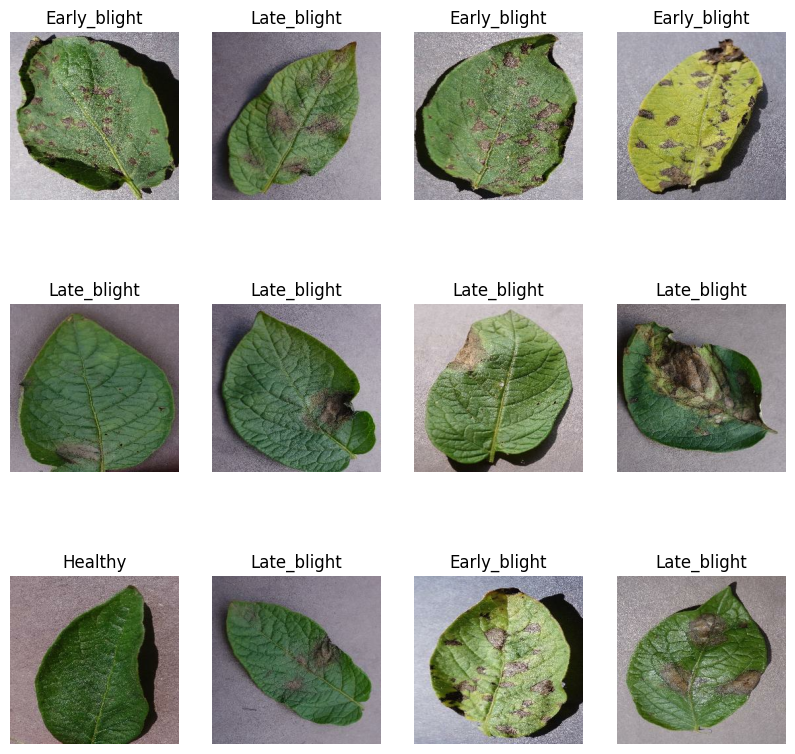

In [46]:
plt.figure(figsize = (10,10))  ## It is used to increase the size of the images
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax= plt.subplot(3,4,i+1)         ## it make the dabba thing if the axis ##
        plt.imshow(image_batch[i].numpy().astype("uint8"))  ## In this line imshow function is used to display the array disemsion of images into the complete images
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Split the Data
80% --> Train <br>
10% --> Validation <br>
10% --> Test


In [47]:
#image_count = 0.8
int(len(dataset) * 0.8)


43

In [48]:
train_ds = dataset.take(54)
len(train_ds)

54

In [49]:
test_ds = dataset.skip(54)
len(test_ds)    ##### But here the test data is 20% we have to divide it into the validation data also

0

In [50]:
val_size = 0.1
val = int(len(dataset) * val_size)
val

5

In [51]:
val_ds = test_ds.take(val)
len(val_ds)

0

In [52]:
train_ds = test_ds.skip(6)
len(train_ds)

0

# Wrapping these code in one function

In [53]:
def get_dataset_partition(ds,train_split = 0.8,var_split = 0.1,test_split = 0.1,shuffle = True,shuffle_size = 1000):
    assert(train_split + var_split + test_split) == 1   ## [ASSERT] is used to firstly check the condition then move further

    ds_size = len(ds)

    train_size = int(ds_size * train_split)
    val_size = int(ds_size * var_split)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds 

In [54]:
train_ds,val_ds,test_ds = get_dataset_partition(dataset)

In [55]:
len(train_ds)

43

In [56]:
len(test_ds)

6

# Cache,Prefetch,Shuffle

In [57]:
train_ds.cache().shuffle(1000).prefetch(buffer_size = (tf.data.AUTOTUNE))

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [58]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch/256)

tf.Tensor(
[[[[0.48046875 0.39453125 0.4453125 ]
   [0.46875    0.3828125  0.43359375]
   [0.45703125 0.37109375 0.421875  ]
   ...
   [0.60546875 0.57421875 0.6328125 ]
   [0.56640625 0.53515625 0.59375   ]
   [0.6640625  0.6328125  0.69140625]]

  [[0.44921875 0.36328125 0.4140625 ]
   [0.44921875 0.36328125 0.4140625 ]
   [0.44921875 0.36328125 0.4140625 ]
   ...
   [0.66015625 0.62890625 0.6875    ]
   [0.6171875  0.5859375  0.64453125]
   [0.55859375 0.52734375 0.5859375 ]]

  [[0.4296875  0.34375    0.39453125]
   [0.44921875 0.36328125 0.4140625 ]
   [0.4609375  0.375      0.42578125]
   ...
   [0.62890625 0.59765625 0.65625   ]
   [0.6328125  0.6015625  0.66015625]
   [0.5859375  0.5546875  0.61328125]]

  ...

  [[0.40625    0.33984375 0.40234375]
   [0.39453125 0.328125   0.390625  ]
   [0.42578125 0.359375   0.421875  ]
   ...
   [0.59375    0.58203125 0.6640625 ]
   [0.6796875  0.66796875 0.75      ]
   [0.56640625 0.5546875  0.63671875]]

  [[0.453125   0.38671875 0.449218

### <b>*</b> Resizing and Rescaling the images
#### <u>Creating a Layer for Resizing and Normalization</u><br>
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [59]:
from tensorflow.keras import Sequential


In [60]:
resing_and_rescaling = Sequential([
    layers.Resizing(Image_size, Image_size),
    layers.Rescaling(1.0/256)
])


# <u> DATA AUGMENTATION </u>

In [61]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

## <u>Model training Using CNN(Convolutional neural network)<br>

In [62]:
Input_shape= (Batch_size,Image_size,Image_size,Channels)
n_classes = 3
model = models.Sequential([
    resing_and_rescaling,
    data_augmentation,
    layers.Conv2D(32,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax') # in_class is passed for the number of classes 
    ])
model.build(input_shape = Input_shape )

In [63]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)       │ (40, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (40, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (40, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (40, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (40, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (40, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (40, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (40, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (40, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (40, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (40, 12544)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (40, 64)               │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (40, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,323 (3.42 MB)

 Trainable params: 896,323 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

#### COMPILING THE MODEL

In [64]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [72]:
model.fit(
    train_ds,
    batch_size = Batch_size,
    validation_data = val_ds,
    verbose = 2,
    epochs = 30
)

Epoch 1/30
43/43 - 28s - 658ms/step - accuracy: 0.9709 - loss: 0.0696 - val_accuracy: 0.9150 - val_loss: 0.2430
Epoch 2/30
43/43 - 27s - 638ms/step - accuracy: 0.9744 - loss: 0.0704 - val_accuracy: 0.8250 - val_loss: 0.6532
Epoch 3/30
43/43 - 28s - 655ms/step - accuracy: 0.9663 - loss: 0.0947 - val_accuracy: 0.8300 - val_loss: 0.5659
Epoch 4/30
43/43 - 29s - 671ms/step - accuracy: 0.9727 - loss: 0.0797 - val_accuracy: 0.9550 - val_loss: 0.1087
Epoch 5/30
43/43 - 29s - 681ms/step - accuracy: 0.9547 - loss: 0.1200 - val_accuracy: 0.9100 - val_loss: 0.2470
Epoch 6/30
43/43 - 30s - 695ms/step - accuracy: 0.9663 - loss: 0.0879 - val_accuracy: 0.9850 - val_loss: 0.0339
Epoch 7/30
43/43 - 34s - 800ms/step - accuracy: 0.9599 - loss: 0.1144 - val_accuracy: 0.9350 - val_loss: 0.2127
Epoch 8/30
43/43 - 36s - 832ms/step - accuracy: 0.9808 - loss: 0.0512 - val_accuracy: 0.8550 - val_loss: 0.6986
Epoch 9/30
43/43 - 34s - 779ms/step - accuracy: 0.9587 - loss: 0.1167 - val_accuracy: 0.8600 - val_loss:

In [66]:
score = model.evaluate(test_ds)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9291 - loss: 0.2311


#Predicting the value

In [67]:
for sample in test_ds.take(5):
    print(sample)


(<tf.Tensor: shape=(40, 256, 256, 3), dtype=float32, numpy=
array([[[[192., 188., 187.],
         [208., 204., 203.],
         [204., 200., 199.],
         ...,
         [226., 221., 227.],
         [175., 170., 176.],
         [180., 175., 181.]],

        [[188., 184., 183.],
         [203., 199., 198.],
         [211., 207., 206.],
         ...,
         [213., 208., 214.],
         [193., 188., 194.],
         [191., 186., 192.]],

        [[211., 207., 206.],
         [210., 206., 205.],
         [217., 213., 212.],
         ...,
         [219., 214., 220.],
         [216., 211., 217.],
         [194., 189., 195.]],

        ...,

        [[156., 149., 156.],
         [153., 146., 153.],
         [171., 164., 171.],
         ...,
         [142., 137., 144.],
         [150., 145., 152.],
         [157., 152., 159.]],

        [[130., 123., 130.],
         [143., 136., 143.],
         [172., 165., 172.],
         ...,
         [124., 119., 126.],
         [136., 131., 138.],
       

In [68]:
samples = list(test_ds.take(5))
predictions = model.predict(samples)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


In [69]:
print(model.input_shape)



(40, 256, 256, 3)


In [70]:
test_ds = test_ds.map(lambda x, y: (x[0], y))  # Picks the first frame


In [71]:
for sample in test_ds.take(1):
    print(sample)

(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[155., 134., 133.],
        [168., 147., 146.],
        [125., 104., 103.],
        ...,
        [207., 193., 190.],
        [209., 195., 192.],
        [193., 179., 176.]],

       [[133., 112., 111.],
        [150., 129., 128.],
        [128., 107., 106.],
        ...,
        [197., 183., 180.],
        [207., 193., 190.],
        [201., 187., 184.]],

       [[162., 141., 140.],
        [147., 126., 125.],
        [132., 111., 110.],
        ...,
        [197., 183., 180.],
        [200., 186., 183.],
        [194., 180., 177.]],

       ...,

       [[145., 121., 121.],
        [155., 131., 131.],
        [143., 119., 119.],
        ...,
        [154., 139., 144.],
        [155., 140., 145.],
        [157., 142., 147.]],

       [[135., 111., 111.],
        [146., 122., 122.],
        [136., 112., 112.],
        ...,
        [152., 137., 142.],
        [153., 138., 143.],
        [155., 140., 145.]],

       [[129., 1